<a href="https://colab.research.google.com/github/Jinyu-Luo/CHL5230-Datathon4/blob/main/16_CHL5230_Datathon4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install statsmodels
!pip install category_encoders
!pip install klib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [2]:
# importing PyTorch library as 't' for convenience
import torch as t

# importing other necessary libraries
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

import io
import seaborn as sns

from statsmodels.imputation import mice
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import klib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# upload the data
from google.colab import files
uploaded = files.upload()

Saving datathon4.csv to datathon4.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['datathon4.csv']))
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


# Raw Data Exploration

In [5]:
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Variable of Interest**

In [6]:
df['hospital_death'].mean()

0.08630183289173836

## Visualize the distribution of Body System Damage

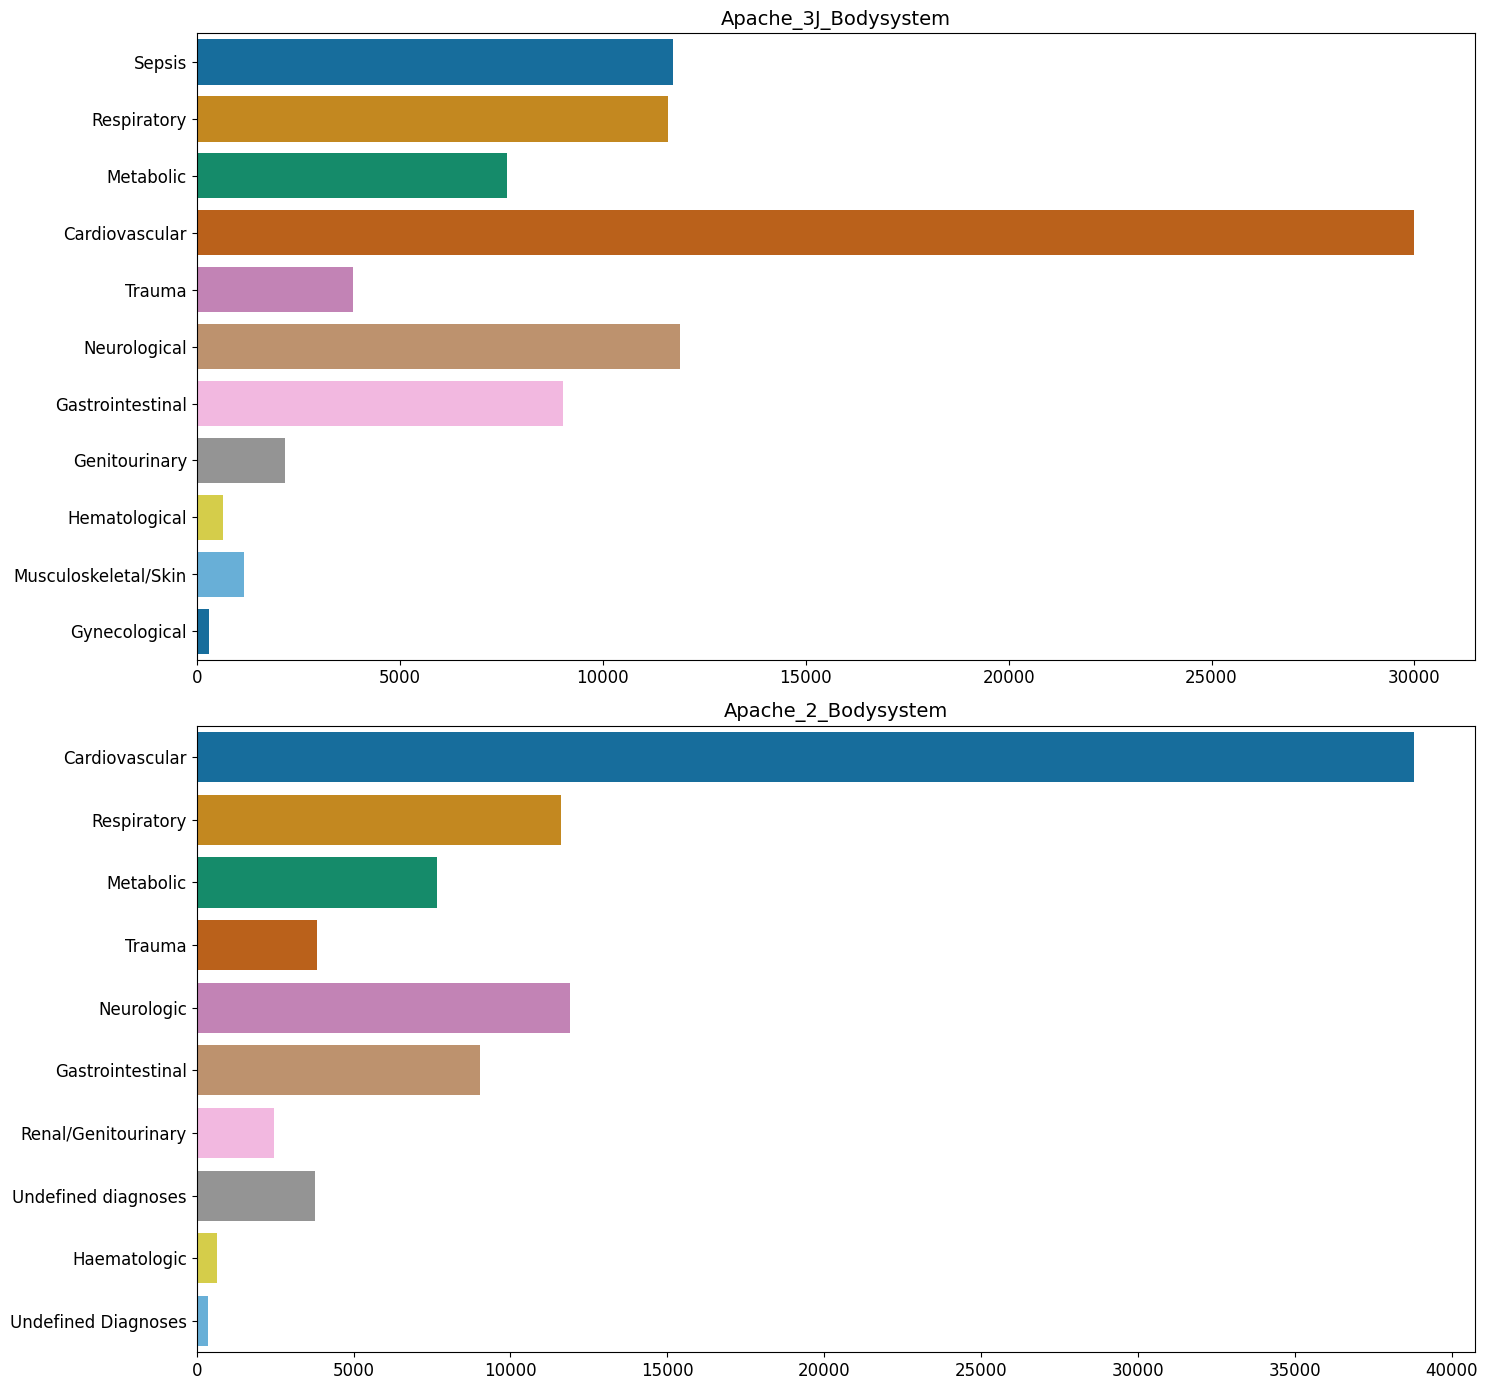

In [7]:
bodysystem = ['apache_3j_bodysystem', 'apache_2_bodysystem']
plt.figure(figsize = (15, 14))

for i, variable in enumerate(bodysystem, 1):
  plt.subplot(2, 1, i)
  sns.countplot(data=df, y=variable, palette="colorblind")
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(variable.title(), fontsize=14)
  plt.xlabel('')
  plt.ylabel('')

plt.tight_layout()
plt.show()  # Show the plot

The column `apache_3j_bodysystem` is the primary reason for ICU admission into different body systems according to the APACHE III-J methodology. Each category represents the primary body system affected or the primary system that the illness is associated with.

We see that the majority patients who admitted to ICU had the illness mainly appear in cardiovascular system.

## Check Uniqueness

Ensure that each identifier is unique and remove duplicates if exist.

In [8]:
# Checking for uniqueness in 'encounter_id', 'hospital_id', and 'patient_id'
unique_encounter_id = df['encounter_id'].is_unique
unique_patient_id = df['patient_id'].is_unique

print(f"Is 'encounter_id' unique for each record? {unique_encounter_id}")
print(f"Is 'patient_id' unique for each record? {unique_patient_id}")


Is 'encounter_id' unique for each record? True
Is 'patient_id' unique for each record? True


The results suggest that each encounter in the ICU is distincly recorded and each patient is uniquely identified in the dataset.

# Research Objective

1. Test the predictive performance of the dataset on hospital mortality in individuals admitted for a Cardiovascular-related complication, using a logistic regression classifier and neural network model
2. The belief that [the conceptual variables] are strong predictors of hospital mortality in individuals admitted for a Cardiovascular-related complication, using a combined Naive Bayes model

The APACHE III scoring system appears to have a higher discriminative power compared to the APACHE II scoring system. On multiple occasions, the APACHE II system under-predicted the actual in-hospital mortality rate.Therefore we should conceptualize our model with variables that were used to predict the highest possible APACHE III score.

Variables that would be interesting to include is ***wbc_apache - The white blood cell count measured during the first 24 hours which results in the highest APACHE III score*** as this has been an indicator for in-hospital mortality and has been used as a predictor in many clinical studies.

# Data Preprocessing

## Data Cleaning

### Columns Removal

The code in the following chunk clean the data by steps as below:

1. Removes duplicate and empty row or columns using the package `klib`.

2. Drop ID columns

3. Given the research objective, we select observations with cardiovascular system damaged according to APACHE-III J result.

4. Drop columns (`apache_2_bodysystem`, `apache_3j_bodysystem`) that indicates the damaged body system.

5. Drop `apache_2_diagnosis` because we only focused on APACHE-III; drop the prediction results by APACHE scores: `apache_4a_hospital_death_prob` and `apache_4a_icu_death_prob`.

In [9]:
# Removes duplicate and empty row/col
df = klib.data_cleaning(df)
print(df.info())

# Drop ID and information label columns
columns_to_drop = ['hospital_admit_source','icu_admit_source','icu_id',
                   'encounter_id','patient_id','hospital_id']
df.drop(columns_to_drop, axis = 1, inplace=True)

# Select the target population
card_df = df[df['apache_3j_bodysystem'] == 'Cardiovascular']

# Drop columns indicating APACHE score
card_df.drop(['apache_2_bodysystem', 'apache_3j_bodysystem'],
              axis = 1, inplace = True)

# Remove predicted probabilities based on APACHE IV
card_df.drop(['apache_2_diagnosis','apache_4a_hospital_death_prob',
           'apache_4a_icu_death_prob'], axis = 1, inplace=True)

Shape of cleaned data: (91712, 179) - Remaining NAs: 5237705


Dropped rows: 1
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 7
     of which 1 single valued.     Columns: ['readmission_status']
Dropped missing values: 505787
Reduced memory by at least: 70.76 MB (-54.37%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Columns: 179 entries, encounter_id to apache_2_bodysystem
dtypes: category(8), float32(164), int16(2), int32(2), int8(3)
memory usage: 59.4 MB
None


Left with 29999 observations and 177 features.

### Check Missing

Count the number of features that is greater than 90%, 80%, 70%, and 60%.

In [10]:
# Calculate the percentage of missing
missing_perc = card_df.isnull().mean()*100

def countMissingCols(data):
  dicts = {}
  count90 = 0
  count80 = 0
  count70 = 0
  count60 = 0

  for column, perc in data.iteritems():
    if perc >= 90:
      count90+=1
    elif 80 <= perc < 90:
      count80+=1
    elif 70 <= perc < 80:
      count70+=1
    elif 60 <= perc < 70:
      count60+=1
  dicts['missing values > 90%: '] = count90
  dicts['80% <= missing values < 90%: '] = count80
  dicts['70% <= missing values < 80%: '] = count70
  dicts['60% <= missing values < 70%: '] = count60
  for key, val in dicts.items():
    print(key, val)
countMissingCols(missing_perc)

missing values > 90%:  0
80% <= missing values < 90%:  4
70% <= missing values < 80%:  31
60% <= missing values < 70%:  20


In [11]:
# List of Arterial Blood Gas Variables
abg_variables = ['fio2_apache', 'paco2_apache', 'paco2_for_ph_apache',
                 'pao2_apache', 'ph_apache']

# Check if rows with a missing value in one ABG variable also have missing values in others
missing_in_all_abg = card_df[abg_variables].isnull().all(axis=1).sum()
missing_in_any_abg = card_df[abg_variables].isnull().any(axis=1).sum()

print(f"Number of rows missing in all ABG variables: {missing_in_all_abg}")
print(f"Number of rows missing in any ABG variable: {missing_in_any_abg}")

Number of rows missing in all ABG variables: 22197
Number of rows missing in any ABG variable: 22197


By examining the percentage of missing for columns with missing greater than 60%, we found that Arterial Blood Gas (ABG) Variables,

- `fio2_apache`
- `paco2_apache`
- `paco2_for_ph_apache`
- `pao2_apache`
- `ph_apache`

, all have the exact same percentage (around 74%) of missing values, suggesting that the majority of the observation did not receive any of the measurement during the first 24 hours of unit admission. Therefore, we will create a binary variable indicating whether or not arterial blood gas being measured during the first 24 hours of unit admission and remove the above mentioned columns.

It seems like the missingness in the Arterial Blood Gas (ABG) variables is completely overlapping - that is, whenever one of these variables is missing, all of them are missing. Therefore, we can consider to create ONE indicator variable to represent whether any ABG measurements were taken.

In [12]:
# Create a single binary indicator variable
card_df['abg_measured'] = card_df[abg_variables].notnull().all(axis=1).astype(int)

# Check unique values in 'abg_measured'
print("Unique values in 'abg_measured':", card_df['abg_measured'].unique())

Unique values in 'abg_measured': [1 0]


### Remove Features with over 60% missings

In [13]:
# Find the indices of columns with over 60% missing values
columns_to_drop = missing_perc[missing_perc>=60].index

# Remove these columns
data = card_df.drop(columns = columns_to_drop)

data.shape

# uncomment the line below to check columns in current dataframe
# data.columns.tolist()

(29999, 114)

The dataset left with 114 columns.

### Remove Observations without Gender Information

Since there is only 9 observations without gender information, and it is unethical to randomly impute gender for these cohorts, we choose to remove them from the dataset.

In [14]:
# Calculate the number of missing in gender
gender_missing = data['gender'].isnull().sum()
print(f"Missing values in 'gender': {gender_missing}")

# Remove observations without gender information
data.dropna(subset=['gender'], inplace = True)

Missing values in 'gender': 9


## Data Imputation

### Impute Missing BMI using Height and Weight

In [15]:
# Function to calculate BMI
def calculate_bmi(weight, height):
  if height > 0:
    height_in_meters = height/100 # convert height to meters
    bmi = weight / (height_in_meters ** 2)
    return bmi
  else:
    return None

# Impute BMI where height and weight are available
data.loc[card_df['bmi'].isnull(), 'bmi'] = card_df.apply(
    lambda row: calculate_bmi(row['weight'], row['height'])
    if pd.notnull(row['weight']) and pd.notnull(row['height'])
    else None,
    axis=1
)

# Check missings in BMI
data['bmi'].isnull().sum()

# Remove height and weight since they are redundant with BMI
data.drop(['height', 'weight'], axis = 1, inplace = True)

# Impute the rest mising BMI with median value
# Calculate the median value of the 'bmi' column
bmi_median = data['bmi'].median()

# Impute missing values in 'bmi' with the median value
data['bmi'].fillna(bmi_median, inplace=True)

# Check if there are any missing values left in 'bmi'
missing_after = data['bmi'].isnull().sum()
print(f"Missing values in 'bmi' after imputation: {missing_after}")

Missing values in 'bmi' after imputation: 0


### Imputation for Ethnicity  

- Rename the category "Other/Unknown" as "Others".  
- Replace NaNs with "Others"



In [16]:
data['ethnicity'].unique()
data["ethnicity"].replace({"Other/Unknown": "Others"}, inplace = True)
data["ethnicity"].fillna("Others", inplace = True)

### Imputation for Important Measurement Features

`bun_apache` and `creaatinine_apache` are two important features for indicating the renal health status, so we apply multiple imputation using the `mice_imputer`.

In [17]:
# Create an IterativeImputer object
mice_imputer = IterativeImputer()

# Impute bun_apache and creatinine_apache using multiple imputation
columns_to_impute = ['bun_apache', 'creatinine_apache']

# Perform the imputation
data[columns_to_impute] = mice_imputer.fit_transform(data[columns_to_impute])
data[columns_to_impute].isnull().sum()

bun_apache           0
creatinine_apache    0
dtype: int64

### Imputation of Age

In the following code chunk, we

1. Create a new dataframe that has only age column.
2. Add columns which are imputed with mean, median, and mode values accordingly.  
3. Have a separate KNN imputation of age using features that might be influence by age, including `bmi`, `apache_3j_diagnosis`, `arf_apache`, `bun_apache`, and `creatinine_apache`.  
4. Plot the distribution of age and imputed age by different imputation values.

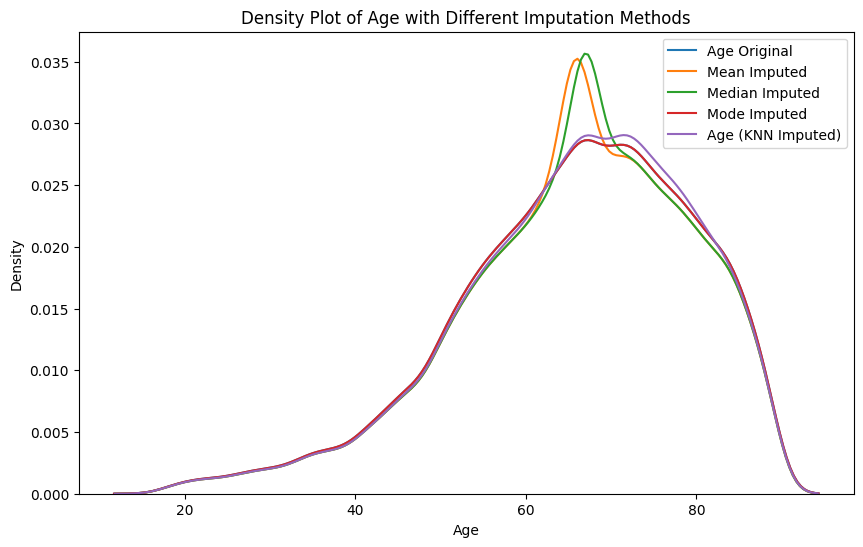

In [19]:
from sklearn.impute import KNNImputer

# Create a subset
df_age = data[['age']]

# Assigning differently imputed values to different columns
df_age['Age_Mean'] = df_age['age'].fillna(df_age['age'].mean())
df_age['Age_Median'] = df_age['age'].fillna(df_age['age'].median())
df_age['Age_Mode'] = df_age['age'].fillna(df_age['age'].mode())

# Select only columns that is helpful in KNN imputation for age
age_cols = ["age", "bmi", "apache_3j_diagnosis", "arf_apache",
            "bun_apache", "creatinine_apache"]
df_age_cols = data[age_cols]

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform the dataset
df_imputed_age = imputer.fit_transform(df_age_cols)

# Convert the imputed data back to a DataFrame
df_imputed_age = pd.DataFrame(df_imputed_age, columns=df_age_cols.columns)

# Reset the indices of both DataFrames
df_age.reset_index(drop=True, inplace=True)
df_imputed_age.reset_index(drop=True, inplace=True)

# Replace the 'age' column in 'data' with the 'age' column from 'df_imputed_age'
df_age['KNN_age'] = df_imputed_age['age']

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Plot density plots for each age column
sns.kdeplot(df_age['age'], label='Age Original')
sns.kdeplot(df_age['Age_Mean'], label='Mean Imputed')
sns.kdeplot(df_age['Age_Median'], label='Median Imputed')
sns.kdeplot(df_age['Age_Mode'], label='Mode Imputed')
sns.kdeplot(df_age['KNN_age'], label='Age (KNN Imputed)')

# Add titles and labels
plt.title('Density Plot of Age with Different Imputation Methods')
plt.xlabel('Age')
plt.ylabel('Density')

# Show legend
plt.legend()

# Display the plot
plt.show()

Examining the distribution plot above, we see that the distribution of KNN imputed age is very similar to the original age distribution. Therefore, we replace the age column in the original dataset by the imputed age. Moreover, according to literatures, people with cardiovascular system damage are often greater than 40 years old. Therefore, we will filter out all patients that are younger than 40.  

In [20]:
# Reset the indices of both DataFrames
data.reset_index(drop=True, inplace=True)
df_imputed_age.reset_index(drop=True, inplace=True)

# Replace the 'age' column in 'data' with the 'age' column from 'df_imputed_age'
data['age'] = df_imputed_age['age']
age_missing_n = data['age'].isnull().sum()
print(f"Missing values in 'age' after imputation: {age_missing_n}")

# Filter out observations where age is greater than or equal to 40
data = data[data['age'] >= 40]

Missing values in 'age' after imputation: 0


### Impute the rest Numerical Columns with Median

In [21]:
#check for the missing values in other columns
col_w_mv = data.columns[data.isnull().any()].tolist()
col_w_mv

['gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_

In [22]:
##Deal with missing values
bin_col = ['elective_surgery', 'readmission_status', 'apache_post_operative', 'arf_apache', 'gcs_unable_apache',
          'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
          'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'gender']

for col in col_w_mv:
    if col not in ['ethnicity', 'icu_stay_type', 'icu_type', 'age']:

        ##Remove rows of binary missing values
        if col in bin_col:
            data = data[data[col].notna()]

        ##Fill numeric missing values with medium
        else:
            data[col].fillna(data[col].median(), inplace=True)

## Feature Selection by Variance Threshold

Since we still have over 100 features in the dataset, we now perform feature selection by filter out all features with variance lower than 0.25 because these features don't provide that much information for classification.

In [23]:
from sklearn.feature_selection import VarianceThreshold

numerical_cols = data.select_dtypes(include=['int8', 'float32', 'float64']).columns
df_numerical = data[numerical_cols]
df_numerical.drop(['hospital_death','age','bmi'], axis = 1, inplace = True)

# Removing both constant and quasi-constant
var_thr = VarianceThreshold(threshold = 0.25)
var_thr.fit(df_numerical)

# Uncomment see the result:  True: High Variance; False: Low Variance
# var_thr.get_support()

concol = [column for column in df_numerical.columns
          if column not in df_numerical.columns[var_thr.get_support()]]

# Print column names with low variance
# We will drop them from the data set
for features in concol:
    print(features)

selected_features = ['hospital_death','age','bmi', 'gender', 'ethnicity',
                     'icu_stay_type','icu_type']+ df_numerical.columns[var_thr.get_support()].tolist()

data_clean = data[selected_features]

print(data_clean.shape)

len(selected_features)

elective_surgery
apache_post_operative
arf_apache
gcs_unable_apache
intubated_apache
ventilated_apache
d1_inr_min
h1_inr_min
aids
cirrhosis
diabetes_mellitus
hepatic_failure
immunosuppression
leukemia
lymphoma
solid_tumor_with_metastasis
(28582, 95)


95

## Encoding and Data Transformation

### Encode Gender

In [24]:
data_clean['gender'].unique()

data_clean['gender'].replace({'F' : 1, 'M' : 0}, inplace=True)

### Categorical Feature Transformation Functions

We will impute the rest of categorical feature during the spliting process using functions defined below.

In [25]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# Define a function to preprocess and transform input data
def fit_transform(input_df):
    # Initialize transformers and imputers
    ethnicity_transformer = ce.TargetEncoder()
    stayType_transformer = ce.TargetEncoder()
    icuType_transformer = ce.TargetEncoder()

    imputer = IterativeImputer(max_iter=10, random_state=0)
    st_x = StandardScaler()

    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # Encode 'ethnicity' column if it exists
    if 'ethnicity' in df.columns:
        df['ethnicity'] = ethnicity_transformer.fit_transform(
            df['ethnicity'].to_numpy().reshape(-1, 1), df['hospital_death'].to_numpy()
        )

    # Encode 'icu_stay_type' column if it exists
    if 'icu_stay_type' in df.columns:
        df['icu_stay_type'] = stayType_transformer.fit_transform(
            df['icu_stay_type'].to_numpy().reshape(-1, 1), df['hospital_death'].to_numpy()
        )

    # Encode 'icu_type' column if it exists
    if 'icu_type' in df.columns:
        df['icu_type'] = icuType_transformer.fit_transform(
            df['icu_type'].to_numpy().reshape(-1, 1), df['hospital_death'].to_numpy()
        )

    # Perform imputation and standardization on the feature matrix
    X = imputer.fit_transform(df.drop('hospital_death', axis=1).to_numpy())
    X = st_x.fit_transform(X)

    # Extract the target variable 'Class/ASD'
    Y = df['hospital_death'].to_numpy()

    # Return the preprocessed feature matrix, target variable, and transformers/imputers
    return X, Y, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x

# Define a function to transform new data using pre-trained transformers and imputers
def transform(input_df, ethnicity_transformer, stayType_transformer,
              icuType_transformer, imputer, st_x):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # Encode 'ethnicity' column if it exists
    if 'ethnicity' in df.columns:
        df['ethnicity'] = ethnicity_transformer.transform(
            df['ethnicity'].to_numpy().reshape(-1, 1)
        )

    # Encode 'icu_stay_type' column if it exists
    if 'icu_stay_type' in df.columns:
        df['icu_stay_type'] = stayType_transformer.transform(
            df['icu_stay_type'].to_numpy().reshape(-1, 1)
        )

     # Encode 'icu_type' column if it exists
    if 'icu_type' in df.columns:
        df['icu_type'] = icuType_transformer.transform(
            df['icu_type'].to_numpy().reshape(-1, 1)
        )

    # Perform imputation and standardization on the feature matrix
    X = imputer.transform(df.drop('hospital_death', axis=1).to_numpy())
    X = st_x.transform(X)

    # Return the transformed feature matrix
    return X

## EDA

### The Outcome Variable

In [26]:
import plotly.express as px

counts = data['hospital_death'].value_counts()

# Define your color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in Hospital Death',
    color_discrete_sequence=colors  # apply your colors here
)

# Update layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='Hospital Death'
    ),
    title=dict(
        text='Distribution of Classes in Hospital Death',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()

An 92-8 split suggests that there is severe clasas imbalance in the dataset, with the death population representing approximately 8% of the data and the other 92%.

### Distribution of Age by Gender and Hospital Death Outcome

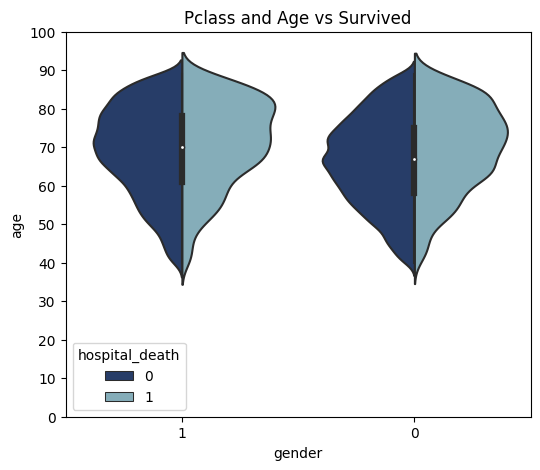

In [27]:
plt.figure(figsize=(6, 5))
sns.violinplot(x="gender", y="age", hue="hospital_death",
               data=data, split=True, palette=['#1c3a73', '#7cb1c2'])
plt.title('Pclass and Age vs Survived')
plt.yticks(range(0, 110, 10))
plt.show()

### Multicollinearity Check

<Axes: >

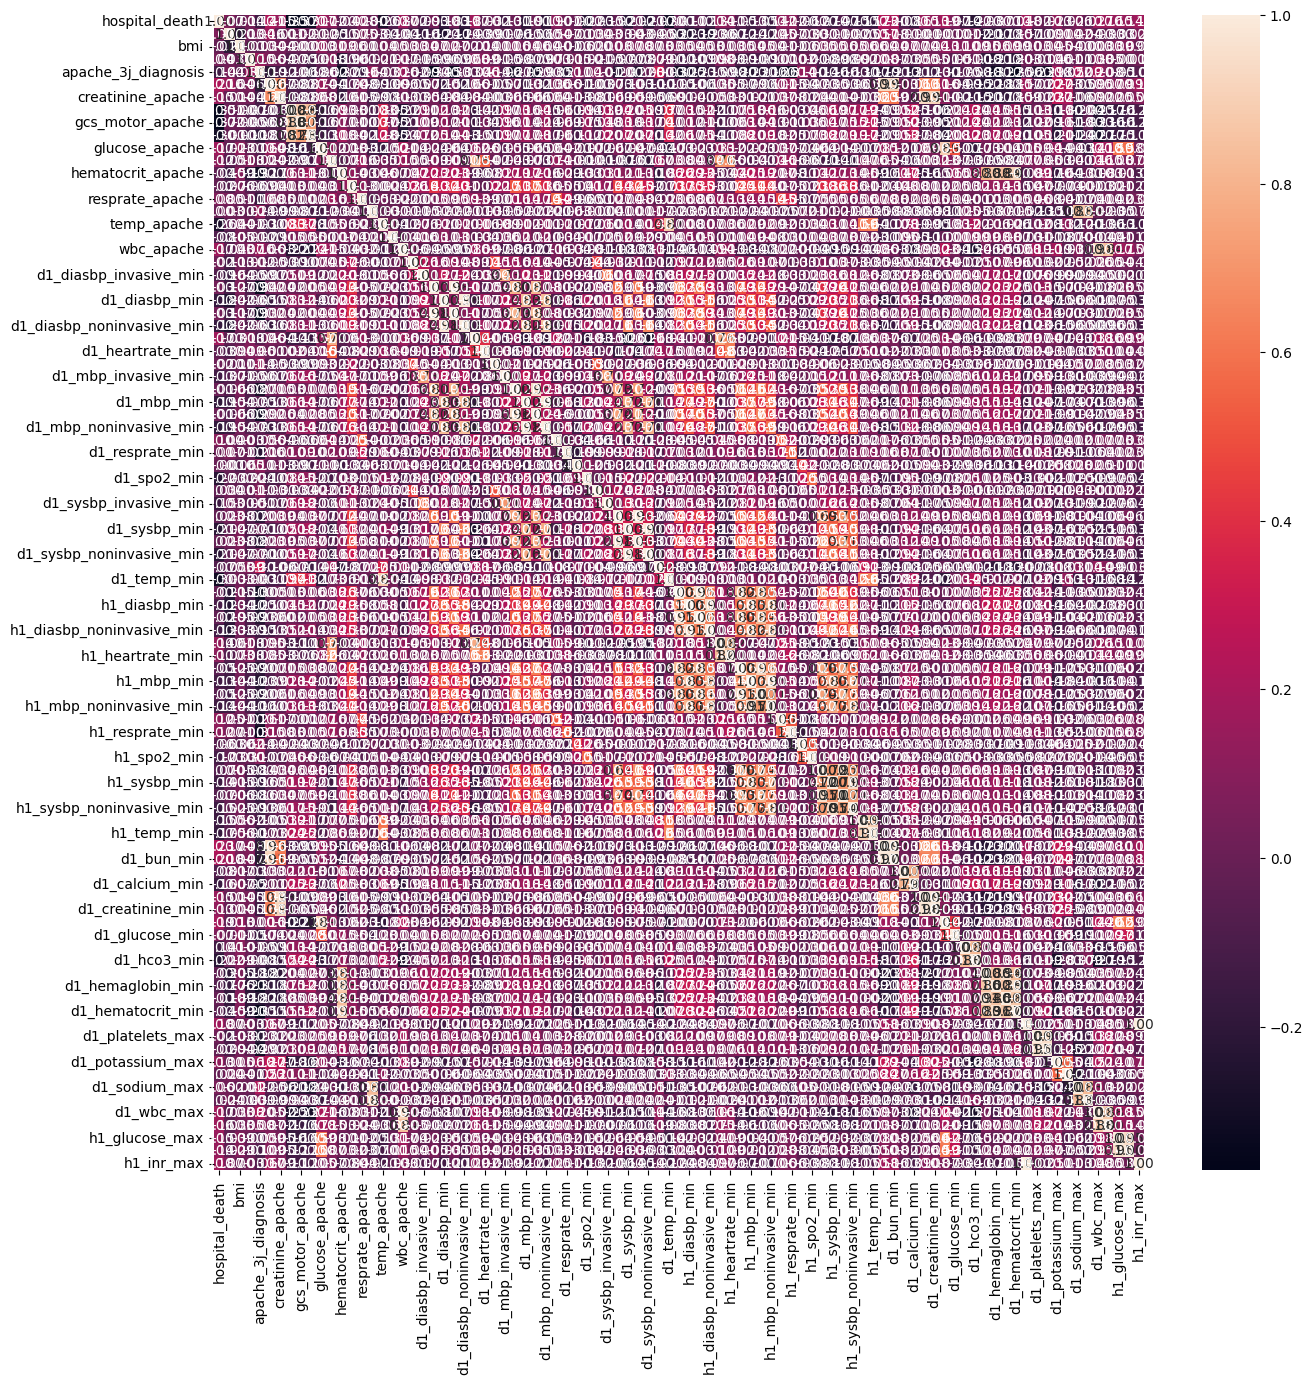

In [28]:
# Calculate the correlation matrix for the first 10 columns
corr_matrix = data_clean.iloc[:, :10].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

# Model Building

Define utility functions for reporting fitting results.

In [29]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

### Recursive Cross Validation Feature Selection

In [39]:
# Import necessary libraries for feature selection and logistic regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Split the data into training and testing sets
train = data.sample(frac=0.7, random_state=10)
test = data.drop(train.index)

# Feature engineering and preprocessing on the training set
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set
X_test = transform(test, ethnicity_transformer, stayType_transformer,
                   icuType_transformer, imputer, st_x)
Y_test = test['hospital_death'].to_numpy()

# Initialize a Logistic Regression model
model = LogisticRegression()

# Define a StratifiedKFold cross-validation
cv = StratifiedKFold(5)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_train, Y_train)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 100


In [31]:
# which columns used and which wasn't
rfecv.support_

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True])

In [32]:
# features ranking low is better
rfecv.ranking_

array([ 1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  8,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  4,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  7,  1,  1,  1,
        1,  1,  1,  1, 10, 12,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  5,
        1,  1,  1,  1,  1, 11,  1,  1,  1])

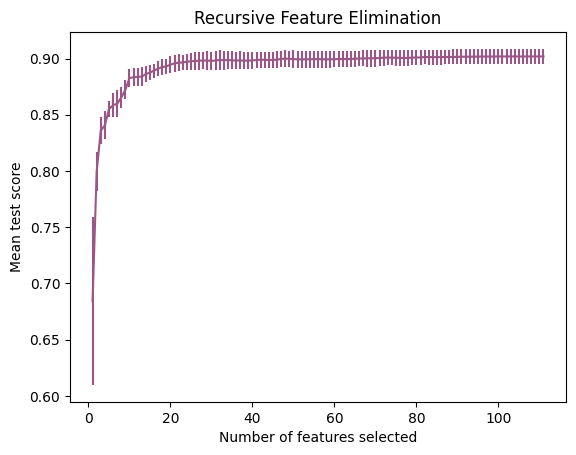

In [40]:
# Calculate the number of different feature selections tested
n_scores = len(rfecv.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Recursive Feature Elimination")

# Show the plot
plt.show()


## Logistic Regression

#### Result with RCV

In [34]:

# Feature engineering and preprocessing on the training set
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set
X_test = transform(test, ethnicity_transformer, stayType_transformer,
                   icuType_transformer, imputer, st_x)
Y_test = test['hospital_death'].to_numpy()

# Select only the features that were chosen by RFECV
X_train = X_train[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# Apply SMOTE on the training data set only
smote = SMOTE(random_state = 42)
X_train_smt, Y_train_smt = smote.fit_resample(X_train, Y_train)

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train_smt, Y_train_smt)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train_smt)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train_smt)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

======== Training Set ==========
AUC :  0.8279070191798306
Accuracy :  0.8277379400260756
Confusion Matrix:
[[15446  3380]
 [ 2962 15028]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     18826
           1       0.82      0.84      0.83     17990

    accuracy                           0.83     36816
   macro avg       0.83      0.83      0.83     36816
weighted avg       0.83      0.83      0.83     36816

======== Test Set ==========
AUC :  0.6419924557038215
Accuracy :  0.8383673469387755
Confusion Matrix:
[[6642  121]
 [1265  547]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      6763
           1       0.82      0.30      0.44      1812

    accuracy                           0.84      8575
   macro avg       0.83      0.64      0.67      8575
weighted avg       0.84      0.84      0.81      8575



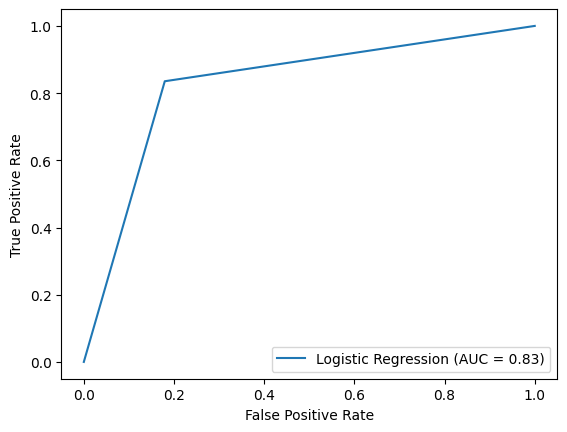

In [35]:
from sklearn.metrics import auc as auc_score
# Plot the ROC curve for the training set
fpr, tpr, thresholds = roc_curve(y_pred_train, Y_train_smt)
roc_auc = auc_score(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          estimator_name='Logistic Regression')
display.plot()

### Result with Features selected by Variance Threshold

======== Training Set ==========
AUC :  0.82686369712454
Accuracy :  0.8268144285093437
Confusion Matrix:
[[15333  3301]
 [ 3075 15107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     18634
           1       0.82      0.83      0.83     18182

    accuracy                           0.83     36816
   macro avg       0.83      0.83      0.83     36816
weighted avg       0.83      0.83      0.83     36816

======== Test Set ==========
AUC :  0.6331440526001195
Accuracy :  0.8279883381924198
Confusion Matrix:
[[6562  130]
 [1345  538]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      6692
           1       0.81      0.29      0.42      1883

    accuracy                           0.83      8575
   macro avg       0.82      0.63      0.66      8575
weighted avg       0.82      0.83      0.79      8575



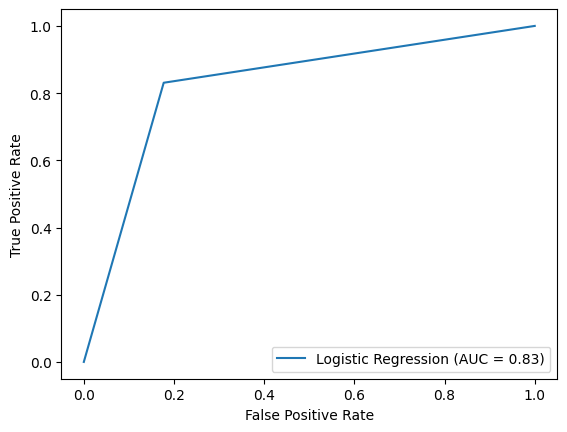

In [36]:
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
train = data_clean.sample(frac=0.7, random_state=10)
test = data_clean.drop(train.index)

# Preprocess and transform the training set using the fit_transform function
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set using the transform function
X_test = transform(test, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x)

# Extract the target variable from the test set
Y_test = test['hospital_death'].to_numpy()

# Apply SMOTE on the training data set only
smote = SMOTE(random_state = 42)
X_train_smt, Y_train_smt = smote.fit_resample(X_train, Y_train)

# Initialize and train a Logistic Regression model with class weights
model = LogisticRegression()
model.fit(X_train_smt, Y_train_smt)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train_smt)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train_smt)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

# Plot the ROC curve for the training set
fpr, tpr, thresholds = roc_curve(y_pred_train, Y_train_smt)
roc_auc = auc_score(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

## Neural Net


### Neural Net Performance with Features selected by Recursive Cross-Validation

In [37]:
# Define the forward pass of the neural network
def forward(input):
  # First hidden layer with tanh activation
  out = tanh(input @ W1 + B1)

  # Second hidden layer with tanh activation
  out = tanh(out @ W2 + B2)

  # Output layer with sigmoid activation (since it's a binary classificati
  out = sigmoid(out @ W3 + B3)
  return out

In [41]:
# Splitting the dataset into training and test sets
train = data.sample(frac=0.7, random_state=10)  # 70% for training
test = data.drop(train.index)  # Remaining data for testing

# Feature engineering and preprocessing on the training set
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set
X_test = transform(test, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x)
Y_test = test['hospital_death'].to_numpy()

# Select only the features that were chosen by RFECV
X_train = X_train[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5
# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((100, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)
# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)
# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(Y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .5

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Text(0, 0.5, 'loss')

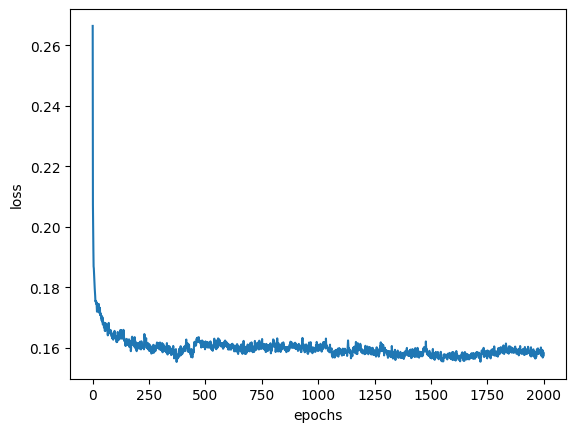

In [45]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [46]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    pred_val = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()  # Convert probabilities to binary predictions
    Y_numpy = Y.numpy()  # Convert tensor to numpy array for comparison

    # Print the validation loss
    print(loss.item())

    # Generate and print the classification report for validation data
    report_val = classification_report(Y_numpy, pred_val, target_names=['Class 0', 'Class 1'])
    print("Validation Classification Report:\n", report_val)


    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs_train = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs_train.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Calculate predictions on the training data
    probs_train = forward(X)
    predictions_train = (probs_train >= 0.5).type(t.LongTensor).view(-1).numpy()  # Convert probabilities to binary predictions
    Y_train_numpy = Y.numpy()  # Convert tensor to numpy array for comparison

    # Print the training loss
    print(loss.item())

    # Generate and print the classification report for training data
    report_train = classification_report(Y_train_numpy, predictions_train, target_names=['Class 0', 'Class 1'])
    print("Training Classification Report:\n", report_train)

0.19638516008853912
Validation Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      7907
     Class 1       0.57      0.38      0.46       668

    accuracy                           0.93      8575
   macro avg       0.76      0.68      0.71      8575
weighted avg       0.92      0.93      0.92      8575

0.15548263490200043
Training Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97     18408
     Class 1       0.73      0.46      0.56      1599

    accuracy                           0.94     20007
   macro avg       0.84      0.72      0.77     20007
weighted avg       0.94      0.94      0.94     20007



The output indicates that the model's loss on the validation set is slightly higher than the loss on the training dataset, suggesting that the probability of overfitting on the training data is very low.  

### Neural Network with Features Selected by Variance Threshold

In [42]:
# Splitting the dataset into training and test sets
train = data_clean.sample(frac=0.7, random_state=10)  # 70% for training
test = data_clean.drop(train.index)  # Remaining data for testing

# Feature engineering and preprocessing on the training set
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set
X_test = transform(test, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x)
Y_test = test['hospital_death'].to_numpy()

# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((94, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)
# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)
# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(Y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .5

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Text(0, 0.5, 'loss')

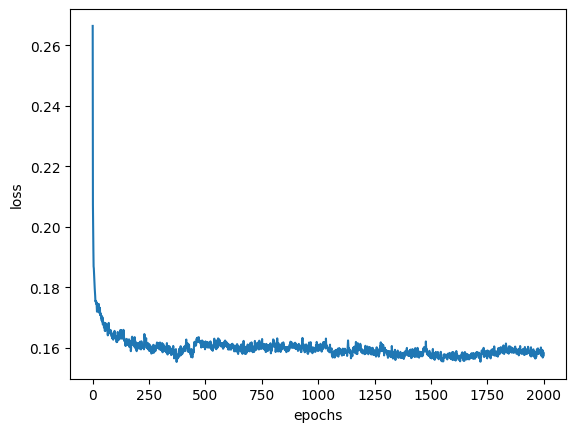

In [43]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [44]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    pred_val = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()  # Convert probabilities to binary predictions
    Y_numpy = Y.numpy()  # Convert tensor to numpy array for comparison

    # Print the validation loss
    print(loss.item())

    # Generate and print the classification report for validation data
    report_val = classification_report(Y_numpy, pred_val, target_names=['Class 0', 'Class 1'])
    print("Validation Classification Report:\n", report_val)


    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs_train = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs_train.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Calculate predictions on the training data
    probs_train = forward(X)
    predictions_train = (probs_train >= 0.5).type(t.LongTensor).view(-1).numpy()  # Convert probabilities to binary predictions
    Y_train_numpy = Y.numpy()  # Convert tensor to numpy array for comparison

    # Print the training loss
    print(loss.item())

    # Generate and print the classification report for training data
    report_train = classification_report(Y_train_numpy, predictions_train, target_names=['Class 0', 'Class 1'])
    print("Training Classification Report:\n", report_train)

0.19638516008853912
Validation Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      7907
     Class 1       0.57      0.38      0.46       668

    accuracy                           0.93      8575
   macro avg       0.76      0.68      0.71      8575
weighted avg       0.92      0.93      0.92      8575

0.15548263490200043
Training Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97     18408
     Class 1       0.73      0.46      0.56      1599

    accuracy                           0.94     20007
   macro avg       0.84      0.72      0.77     20007
weighted avg       0.94      0.94      0.94     20007



## Naive Bayes

In [47]:
print(data_clean.isnull().sum())

hospital_death    0
age               0
bmi               0
gender            0
ethnicity         0
                 ..
d1_wbc_max        0
d1_wbc_min        0
h1_glucose_max    0
h1_glucose_min    0
h1_inr_max        0
Length: 95, dtype: int64


### Preparing conceptual data for re-sampling

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

conceptual_variables = ['hospital_death','creatinine_apache',
                        'urineoutput_apache','bun_apache',
                        'sodium_apache','heart_rate_apache',
                        'wbc_apache','bmi','age','gender','ethnicity']

conceptual_data = data_clean[conceptual_variables]

# Use SimpleImputer to compute the median of features in the training set
imputer = SimpleImputer(strategy='median')

# Assuming train_dataClean is your DataFrame
columns_to_impute = ['sodium_apache', 'heart_rate_apache', 'wbc_apache', 'bmi','urineoutput_apache']

# Use SimpleImputer to compute the median of specified columns in the training set
imputer = SimpleImputer(strategy='median')
imputer.fit(conceptual_data[columns_to_impute])

# Use the same DataFrame for transformation
conceptual_data[columns_to_impute] = imputer.transform(conceptual_data[columns_to_impute])

print(conceptual_data['ethnicity'].value_counts())
## Perform one-hot encoding of ethnicity variable for model
conceptual_data_clean = pd.get_dummies(conceptual_data, columns=['ethnicity'])


Caucasian           22515
African American     2721
Others               1816
Hispanic             1098
Asian                 311
Native American       121
Name: ethnicity, dtype: int64


### Re-sampling of outcome with Synthetic Minority Over-Sampling Technique (SMOTE)

In [49]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# Oversampling technique with SMOTE
X = conceptual_data_clean[['creatinine_apache',
                        'urineoutput_apache','bun_apache',
                        'sodium_apache','heart_rate_apache',
                        'wbc_apache','bmi','age','gender','ethnicity_African American','ethnicity_Asian',
                         'ethnicity_Caucasian','ethnicity_Hispanic',
                         'ethnicity_Native American','ethnicity_Others']]

y = conceptual_data_clean['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Resampling training data
smote_nc = SMOTENC(categorical_features=[8, 9, 10, 11, 12, 13, 14],  random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

training = pd.concat([X_resampled, y_resampled], axis=1)

## Creating testing data
test = pd.concat([X_test, y_test], axis=1)

# Splitting the combined validation and test data into two equal parts for validation and testing, respectively
validation = test.sample(frac = 0.5)
test = test.drop(validation.index)



In [50]:
training.isnull().sum()

creatinine_apache             0
urineoutput_apache            0
bun_apache                    0
sodium_apache                 0
heart_rate_apache             0
wbc_apache                    0
bmi                           0
age                           0
gender                        0
ethnicity_African American    0
ethnicity_Asian               0
ethnicity_Caucasian           0
ethnicity_Hispanic            0
ethnicity_Native American     0
ethnicity_Others              0
hospital_death                0
dtype: int64

### Evaluating Naive Bayes Model on Training Data

AUC :  0.7061617806731812
Accuracy :  0.7061617806731814
Confusion Matrix:
[[14964  3456]
 [ 7369 11051]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73     18420
           1       0.76      0.60      0.67     18420

    accuracy                           0.71     36840
   macro avg       0.72      0.71      0.70     36840
weighted avg       0.72      0.71      0.70     36840



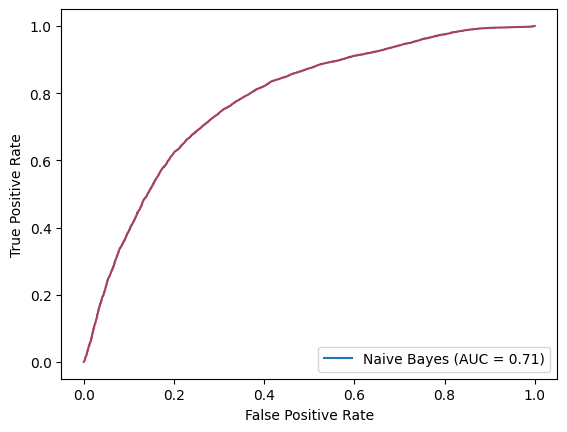

In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report

continuous_variables = ['age','bmi','sodium_apache','wbc_apache','bun_apache',
                        'heart_rate_apache','urineoutput_apache',
                        'creatinine_apache']

categorical_variables = ['gender','ethnicity_African American','ethnicity_Asian',
                         'ethnicity_Caucasian','ethnicity_Hispanic',
                         'ethnicity_Native American','ethnicity_Others']

# Training a Gaussian Naive Bayes model for continuous variables
gnb = GaussianNB()
gnb = gnb.fit(training[continuous_variables].to_numpy(),
              training["hospital_death"])

# Training a Categorical Naive Bayes model for categorical variables
cnb = CategoricalNB()
cnb = cnb.fit(training[categorical_variables].to_numpy(),
              training["hospital_death"])

# Getting joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(training[continuous_variables])
cnb_log_pred = cnb.predict_joint_log_proba(training[categorical_variables])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(training["hospital_death"], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(training["hospital_death"], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

### Evaluating Naive Bayes Model on Validation Data

AUC :  0.669378008624327
Accuracy :  0.7908115671641791
Confusion Matrix:
[[3209  732]
 [ 165  182]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      3941
           1       0.20      0.52      0.29       347

    accuracy                           0.79      4288
   macro avg       0.58      0.67      0.58      4288
weighted avg       0.89      0.79      0.83      4288



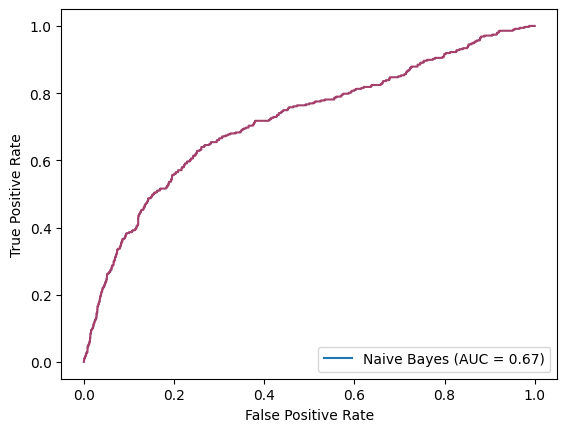

In [52]:
# Getting joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(validation[continuous_variables])
cnb_log_pred = cnb.predict_joint_log_proba(validation[categorical_variables])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(validation["hospital_death"], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(validation["hospital_death"], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

### Evaluating Naive Bayes Model on Testing Data

AUC :  0.6785750089998952
Accuracy :  0.7926288780032656
Confusion Matrix:
[[3217  737]
 [ 152  181]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      3954
           1       0.20      0.54      0.29       333

    accuracy                           0.79      4287
   macro avg       0.58      0.68      0.58      4287
weighted avg       0.90      0.79      0.83      4287



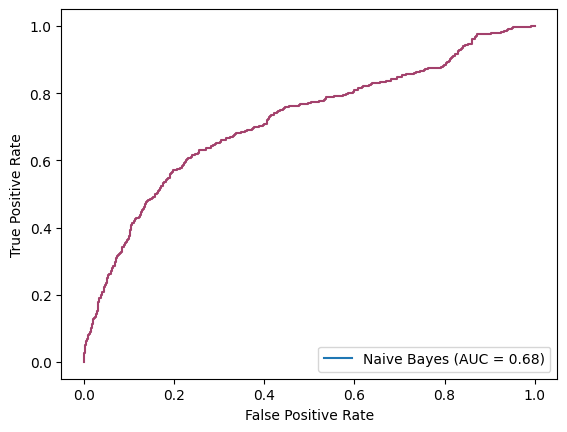

In [53]:
# Getting joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(test[continuous_variables])
cnb_log_pred = cnb.predict_joint_log_proba(test[categorical_variables])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(test["hospital_death"], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(test["hospital_death"], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')